# Runtime

In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.tensorflow_backend.set_session(sess)

Using TensorFlow backend.


In [16]:
from utils import get_largest_categories

In [37]:
%%time
import os
import cv2
import collections

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
sys.path.append('..')
import sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
import time
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from coco_preprocessing import *
from expl_train_utils import *

from keras.backend.tensorflow_backend import set_session
from keras_contrib.applications.resnet import ResNet18
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam, SGD

### Load Dataset

dataDir=''
dataType='val2017'
annFile='../annotations/instances_{}.json'.format(dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
CPU times: user 484 ms, sys: 65.4 ms, total: 549 ms
Wall time: 540 ms


In [39]:
num_cats = 10
largest_categories = get_largest_categories(coco, num_cats)
catId_to_catName = {d['id']: d['name'] for d in used_cats}

### Load All Images

imgIds = sum(
    [coco.getImgIds(catIds=used_id) for used_id in used_ids], 
    [])

print("Loading and preprocessing data...")
# preprocess --> bboxImgs, object_labels, configs, shapelyPolygons
data = [preprocess(coco, img_info, used_ids) for img_info in coco.loadImgs(imgIds)[:100]]
data = np.array(data)
np.random.shuffle(data)

### Using Keras VGG16 Model
model = ResNet18((96, 96, 3), 10)
                 
num_samples = 100
batch_size = 10
num_classes = 10
num_batches = num_samples // batch_size
iteration = 0

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['acc'])
model.load_weights('../saved_weights/5.hdf5')

10 COCO categories used: 
person car truck bench handbag bottle cup bowl chair dining table

Loading and preprocessing data...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [40]:
coco.dataset

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01'},
 'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
   'id': 2,
   'name': 'Attribution-NonCommercial License'},
  {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
   'id': 3,
   'name': 'Attribution-NonCommercial-NoDerivs License'},
  {'url': 'http://creativecommons.org/licenses/by/2.0/',
   'id': 4,
   'name': 'Attribution License'},
  {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
   'id': 5,
   'name': 'Attribution-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
   'id': 6,
   'name': 'Attribution-NoDerivs License'},
  {'url': 'http://flickr.com/commons/usage/',
   'id': 7,
   'name': 'No kn

In [22]:
def preprocess(coco, img, used_ids):
    """Process images into a form that can be input into Keras Models
    
    Args:
        coco (COCO object): coco object of portion of the coco dataset used
        img (np.array): image to preprocess
        used_ids (array): array of ints indicating which classes of coco are being used
        
    Returns:
        bboxImgs (array): array of bounding box images for each object in the image
        object_labels (array): labels for each object in bboxImgs
        configs (array): configs for ground truth segmentation for each object
                         i.e. each config in configs is used like: show_gt_mask(*config)
        shapelyPolygons (array): Shapely Polygons of the ground truth segmentation for each object
    """
    I = np.copy(io.imread(img['coco_url']))
    
    # Get obj seg/bbox annotations of img
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=used_ids, iscrowd=None).copy()
    anns = coco.loadAnns(annIds).copy()
    
    polygons, object_labels, alt_segs, colors, bboxImgs = getPolygonsLabelsMasksColorsBboxImgs(coco, I, anns)
    
    x = len(polygons)
    assert len(object_labels) == x, (x, len(object_labels))
    assert len(alt_segs) == x, (x, len(alt_segs))
    assert len(colors) == x, (x, len(colors))
    assert len(bboxImgs) == x, (x, len(bboxImgs))
    
    # In order to call show_gt_mask(*config)
    configs = []
    for i in range(len(polygons)):
        configs.append((bboxImgs[i], polygons[i], colors[i]))
    
    # In order to check which points are in the Shapely Polygon later
    shapelyPolygons = []
    for seg in alt_segs:
        shapelyPolygons.append(Pgon(pairwise_group(seg[0])))
    
    assert len(configs) == len(shapelyPolygons)
    
    return bboxImgs, object_labels, configs, shapelyPolygons

In [25]:
! ls ../val2017/

000000000139.jpg  000000147729.jpg  000000289594.jpg  000000435206.jpg
000000000285.jpg  000000147740.jpg  000000289659.jpg  000000435208.jpg
000000000632.jpg  000000147745.jpg  000000289702.jpg  000000435299.jpg
000000000724.jpg  000000148508.jpg  000000289741.jpg  000000435880.jpg
000000000776.jpg  000000148620.jpg  000000289938.jpg  000000436315.jpg
000000000785.jpg  000000148662.jpg  000000289960.jpg  000000436551.jpg
000000000802.jpg  000000148707.jpg  000000289992.jpg  000000436617.jpg
000000000872.jpg  000000148719.jpg  000000290081.jpg  000000436738.jpg
000000000885.jpg  000000148730.jpg  000000290163.jpg  000000436883.jpg
000000001000.jpg  000000148739.jpg  000000290179.jpg  000000437110.jpg
000000001268.jpg  000000148783.jpg  000000290248.jpg  000000437205.jpg
000000001296.jpg  000000148957.jpg  000000290293.jpg  000000437239.jpg
000000001353.jpg  000000148999.jpg  000000290592.jpg  000000437331.jpg
000000001425.jpg  000000149222.jpg  000000290619.jpg  000000437351.jpg
000000

In [11]:
x_train = data[:, 0] # Bbox images

# bbox_imgs = []
temp = []
for bbox_imgs in x_train:
    for img in bbox_imgs:
        if len(img.shape) != 3:
            img = np.stack((img,) * 3, -1)
#         bbox_imgs.append(img)
        alt_img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
        temp.append(alt_img)

x_train = np.array(temp)

print(x_train.shape)
print(np.array(bbox_imgs).shape)

y_train = data[:, 1]
y_train = np.array([label[0] for labels in y_train for label in labels])

temp = np.zeros((y_train.shape[0], num_cats))
for ft in used_ids:
    vec = np.zeros(num_cats)
    vec[used_ids.index(ft)] = 1
    temp[np.where(y_train == ft)] = vec

y_train = temp

(737, 96, 96, 3)
(3,)


In [12]:
model.fit(x_train, y_train,
          epochs=1,
          batch_size=128,
          shuffle=False,
          validation_split=0.1,
          verbose=2)

Train on 663 samples, validate on 74 samples
Epoch 1/1
 - 10s - loss: 0.8556 - acc: 0.8326 - val_loss: 1.1480 - val_acc: 0.7838


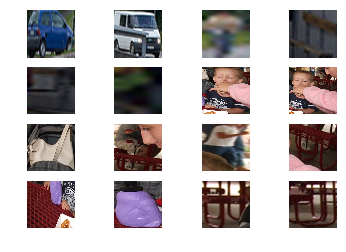

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

for i, image in enumerate(x_train[:16]):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    plt.imshow(image)

plt.show()

In [ ]:
# TODO: Plot with Segmentation

class CocoImage():
    coco_data
    image_array
